# MCMC for a population model $ p(M|\alpha)= M^\alpha$

The purpose of this code is to infer the parameters of population models in which the parameters are drawn from potentially non-analytic expressions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

# Nice plotting options for corner plots.

CORNER_KWARGS = dict(
    smooth=0.2, # smooths out contours. 
    plot_datapoints=True, # choose if you want datapoints
    label_kwargs=dict(fontsize=17.0), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=17.0), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=4, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

In [2]:
def model(d,mu,Sigma_sq):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data              (The noisy generated data where we expect theta to be.)
    - mu                (First  hyperparameter, "param[0]" in MCMC initialization.)
    - Sigma^2 + sigma^2 (Second hyperparameter, "param[1]" in MCMC initialization.)
    
    """
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

from scipy.special import erfc

def pdet_lambda(d_th,mu,Sigma_sq):
    
    """
    selection function for gaussian toy model.
    """
    
    return 0.5 * erfc((d_th - mu)/np.sqrt(2 * Sigma_sq))

In [3]:
andreamean_min_prior = -10.0
mean_max_prior = 10.0

Sigma_sq_min_prior = -10.0
Sigma_sq_max_prior = 10.0

## Case I: no selection effects

### MCMC analysis

In [4]:
def log_likelihood_generic(params, data):
    
    
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
                )
    
    log_likelihood=0
    
    for i in np.arange(N_obs):
        
        mod = model(data[i,:], params[0], params[1])
        log_likelihood += np.log(np.sum(mod)) 
        
    out = np.where(support,log_likelihood,-np.inf)
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf
    
"""
  

#Currently not working!!
 
def log_likelihood_generic_selbias(params, data):
    
    
    
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
                )
    
    
    alpha = pdet_lambda(d_th, params[0], params[1])
    log_likelihood=0
    
    for i in np.arange(N_obs):
        
        mod = model(data[i,:], params[0], params[1])
        log_likelihood += np.log(np.sum(mod/alpha)) 
        
        
    out = np.where(support,log_likelihood,-np.inf)
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf
        
"""  

In [5]:
"""
Parameters
"""

N_obs = 100
N_samp_per_obs = 100

true_mu = 0.5
true_Sigma_sq = 1.5
Sigma = np.sqrt(true_Sigma_sq)
sigma = 0.2
std = np.sqrt(Sigma**2 + sigma**2)

In [6]:
noise = np.random.normal(0,sigma,size = N_obs)

"""
This changes with different models.
"""
theta_draws = np.random.normal(true_mu, Sigma, size = N_obs) #p(theta|lambda)
d_i = noise + theta_draws # p(d|theta)


"""
This does not change with different population models. 
Would change with different observation model, i.e., p(d|theta).
The structure of data is such that Data[i,j] is the jth posterior sample from event i.

"""

d_th = 0.5 #threshold for data.

data=np.zeros((N_obs,N_samp_per_obs))
data_sel_bias=np.zeros((N_obs,N_samp_per_obs))


for i in np.arange(N_obs):
    
    data[i,:]=np.random.normal(d_i[i],sigma,size=N_samp_per_obs)
    
    if d_i[i]> d_th:
        
        data_sel_bias[i,:]=np.random.normal(d_i[i],sigma,size=N_samp_per_obs)
    else:
        data_sel_bias[i,:]=0

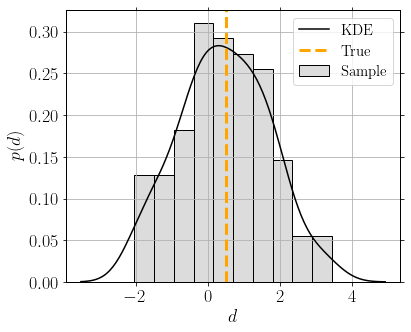

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(d_i,density=True,label='Sample',bins=10,histtype = 'bar',
                               color ='gainsboro', edgecolor='black')
sns.kdeplot(np.array(d_i), label='KDE',c='k')
plt.axvline(x=true_mu, label='True', c='orange',ls='--',lw=3)

plt.xlabel('$d$')
plt.ylabel('$p(d)$')
plt.legend(loc='best')

In [8]:
"""
Choose which data and likelihood.
"""

which_likelihood = log_likelihood_generic
which_data = data

In [9]:
n_iter = 10000
ndim = 2; nwalkers = 16

pos_init0 = [true_mu,true_Sigma_sq]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, which_likelihood, args=[which_data])

sampler.run_mcmc(p0, n_iter, progress=True)

  7%|▋         | 723/10000 [00:15<03:17, 46.95it/s]<ipython-input-2-ce0e593d4395>:14: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt(2*np.pi*Sigma_sq)
  9%|▉         | 939/10000 [00:19<03:11, 47.41it/s]<ipython-input-4-f9a8528c1f2b>:16: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(np.sum(mod))
100%|██████████| 10000/10000 [03:29<00:00, 47.74it/s]


State([[0.45016971 1.69205366]
 [0.42882014 1.62480901]
 [0.30553343 1.92182662]
 [0.53808239 1.54695144]
 [0.47773952 1.38410274]
 [0.52714794 1.34256141]
 [0.47668649 1.74254895]
 [0.58503889 1.05636655]
 [0.68000043 1.4382585 ]
 [0.49230581 1.85730453]
 [0.6792653  2.17801642]
 [0.4927434  1.45684232]
 [0.59088834 1.17054524]
 [0.23688279 1.70541322]
 [0.37749307 1.20237729]
 [0.28891875 1.2582149 ]], log_prob=[297.43458309 297.63700961 295.81193137 297.55407452 297.73345424
 297.41946183 297.21356666 294.07863214 296.02512519 296.6355307
 293.44285189 297.79214983 295.6580053  296.10867778 296.60638232
 296.25604727], blobs=None, random_state=('MT19937', array([1403788713, 2239670430, 2105610763, 1439026037,  801256245,
       3943338563,  994949719, 1935725143,  195487015, 3596407428,
       3777465146,   93255471, 1275071926,  542490737,  516052908,
       2517798481, 2201421746, 1959127249,  983716868,  236619786,
       2329161938, 3886774058, 1968199871, 1255619394,  548497763

In [10]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() - sigma**2 # remove sigma component that we were trating as exact.

In [11]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (136000, 2)
median =  [0.44641835 1.49545745]


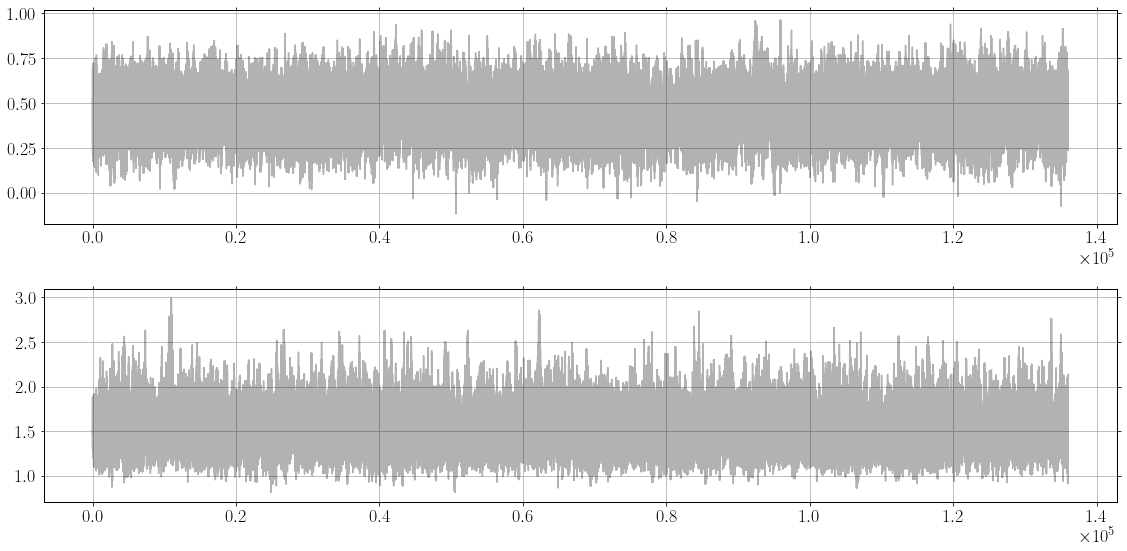

In [12]:
fig,ax = plt.subplots(2,figsize = (16,8))

ax[0].plot(mu_samples, "k", alpha=0.3)
ax[1].plot(Sigma2_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

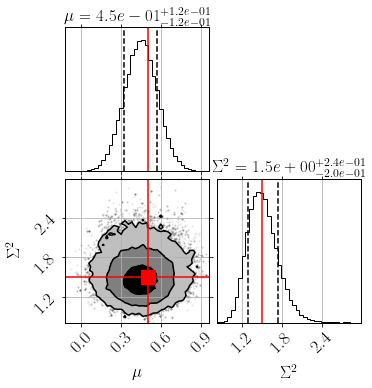

In [13]:
labels = [r'$\mu$',r'$\Sigma^2 $']
truths=[true_mu, true_Sigma_sq]

fig = corner.corner(org_samp, bins=40,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

plt.show()

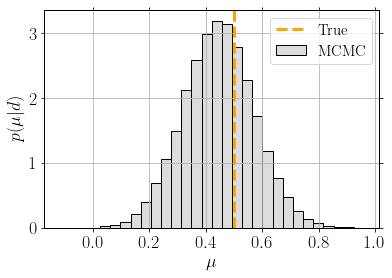

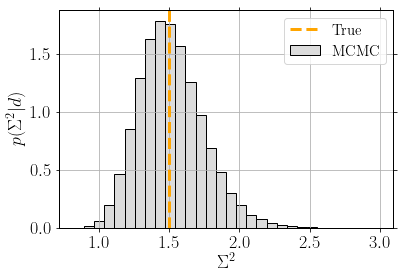

In [14]:
"""
Posteriors with Fisher estimates
"""


_, bins_mu, _= plt.hist(mu_samples, 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')

plt.axvline(x=truths[0], label='True', c='orange',ls='--',lw=3)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

counts_Ssq, bins_Ssq, _=plt.hist(Sigma2_samples, 30, histtype = 'bar',
                        color ='gainsboro', density=True, edgecolor='black', 
                        label='MCMC')

plt.axvline(x=truths[1], label='True', c='orange',ls='--', lw=3)
plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()